Hello Friends,

I have divided this kernel into two parts 

* Part 1 :  EDA for "googleplaystore.csv" and draw insights from the data
* Part 2 :  Sentiment Analysis of the spreadsheet "googleplaystore_user_reviews.csv" and prediction  

Part 1 :  EDA for "googleplaystore.csv" and draw insights from the data

In [204]:
import pandas as pd 
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
import re
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from gensim.models import Word2Vec
from numpy import asarray
from numpy import zeros
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from nltk.tokenize import RegexpTokenizer
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
# general imports
import math
from bs4 import BeautifulSoup
import tensorflow as tf
import numpy as np
import skimage
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
import missingno as msno
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
from collections import  Counter
plt.style.use('ggplot')
stop=set(stopwords.words('english'))
import re
from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [205]:
#Lets load the first csv file 
df = pd.read_csv('../input/google-play-store-apps/googleplaystore.csv')    
df.shape

(10841, 13)

In [206]:
#First look at data
df.sample(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
3931,Like A Boss,FAMILY,4.40000,17069,94M,"500,000+",Free,0,Everyone 10+,Role Playing,"August 1, 2018",1.0.17.2,5.0 and up
6210,Ultimate Background Eraser,PHOTOGRAPHY,4.30000,14453,21M,"1,000,000+",Free,0,Everyone,Photography,"March 13, 2018",1.9,4.1 and up
4969,Local Services ads by Google,BUSINESS,4.10000,7,12M,"1,000+",Free,0,Everyone,Business,"July 17, 2018",3.3.270,4.0 and up
694,Sugar Daddies Dating App,DATING,2.90000,53,14M,"10,000+",Free,0,Mature 17+,Dating,"July 10, 2018",4.1,4.1 and up
3278,HTC Sense Input-LV,TOOLS,3.60000,59,2.3M,"50,000+",Free,0,Everyone,Tools,"April 22, 2014",9.7.753080,4.1 and up


In [207]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [208]:
#Lets check Missing values
df.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

* Many (1474) missing values in rating column
* Current Ver (8) & Andrioid Ver (3)
* Type & Content Rating have 1 each

In [209]:
#Lets see % wise top contributors to missing values 
def missing_values(dff):
    print (round((dff.isnull().sum() * 100/ len(dff)),2).sort_values(ascending=False))

missing_values(df)

Rating           13.60000
Current Ver       0.07000
Android Ver       0.03000
Content Rating    0.01000
Type              0.01000
Last Updated      0.00000
Genres            0.00000
Price             0.00000
Installs          0.00000
Size              0.00000
Reviews           0.00000
Category          0.00000
App               0.00000
dtype: float64


In [210]:
#chek datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


In [211]:
#Describe the numerical data
df.describe()

,Rating
count,9367.00000
mean,4.19334
std,0.53743
min,1.00000
25%,4.00000
50%,4.30000
75%,4.50000
max,19.00000


* 75% of the data lies below 4.5 rating
* min rating is 1
* maximum rating is 19 - seems to be an outlier

* Step 1 : Data cleaning starts

In [212]:
#Variable : Size
# Replace "Varies with device" with a fixed numeric value "999999"
df['Size'].replace(to_replace ="Varies with device",value ="999999", inplace=True) 
# Replace "1000+" with "1000" 
df['Size'].replace(to_replace ="1,000+",value ="1000", inplace=True) 


In [213]:
#Replace small k with capital K
df["Size"] = df["Size"].replace({'k':'K'}, regex=True)
#Replace small m with capital M
df["Size"] = df["Size"].replace({'m':'M'}, regex=True) 

In [214]:
#Multiply the values ending with K  by 1000 and values ending with M ith 1000000  
df.Size = (df.Size.replace(r'[KM]+$', '', regex=True).astype(float) * \
          df.Size.str.extract(r'[\d\.]+([KM]+)', expand=False)
          .fillna(1)
          .replace(['K','M'], [10**3, 10**6]).astype(int))


In [215]:
df["Size"].sample(5)

967       999999.00000
10033    5200000.00000
2903    10000000.00000
6105     5000000.00000
1425    37000000.00000
Name: Size, dtype: float64

In [216]:
#Varibable : Type
# Drop rows with any NaN in the selected columns only
df = df.dropna(how='any', subset=['Type'])
df.Type.isna().sum()
# No missing values for Type column

0

In [217]:
# Get names of indexes for which column Type has value 0
indexNames = df[ df['Type'] == '0' ].index

# Delete these row indexes from dataFrame
df.drop(indexNames , inplace=True)

df["Type"].value_counts()

Free    10039
Paid      800
Name: Type, dtype: int64

In [218]:
#So we have only two categories in "Type" column. Lets convert to numeric ones for our analysis
df["Type"] = df["Type"].map({"Free": 0, "Paid":1})
df["Type"].value_counts()

0    10039
1      800
Name: Type, dtype: int64

In [219]:
df["Type"].sample(5)

4942     0
4704     0
10177    0
2749     0
2879     0
Name: Type, dtype: int64

In [220]:
#Variable : Rating
# Rating Null Values : Fill Null values with value= "No Rating" 
df['Rating'].fillna("No Rating", inplace=True)


In [221]:
#Variable : Current ver
# Current Ver :  Null Values : Fill Null values with value= "No Current Ver" 
df['Current Ver'].fillna("No Current Ver", inplace=True)


In [222]:
#Variable : Andriod ver
# Android Ver :  Null Values : Fill Null values with value= "No Android Ver" 
df['Android Ver'].fillna("No Android Ver", inplace=True)


In [223]:
df.isnull().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
Last Updated      0
Current Ver       0
Android Ver       0
dtype: int64

All Null values are imputed/removed

In [224]:
# Remove $ & ,and Converting price to float
df['Price'] = df['Price'].apply(lambda x: x.replace('$', '').replace(',', '')
                                if isinstance(x, str) else x).astype(float)
df['Price'].apply(type).value_counts()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10839 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10839 non-null  object 
 1   Category        10839 non-null  object 
 2   Rating          10839 non-null  object 
 3   Reviews         10839 non-null  object 
 4   Size            10839 non-null  float64
 5   Installs        10839 non-null  object 
 6   Type            10839 non-null  int64  
 7   Price           10839 non-null  float64
 8   Content Rating  10839 non-null  object 
 9   Genres          10839 non-null  object 
 10  Last Updated    10839 non-null  object 
 11  Current Ver     10839 non-null  object 
 12  Android Ver     10839 non-null  object 
dtypes: float64(2), int64(1), object(10)
memory usage: 1.2+ MB


In [225]:
# Remove + & , and Converting Installs to float 
df['Installs'] = df['Installs'].apply(lambda x: x.replace('+', '').replace(',', '')
                                if isinstance(x, str) else x).astype(float)
df['Installs'].apply(type).value_counts()

<class 'float'>    10839
Name: Installs, dtype: int64

In [226]:
#Convert Reviews from object to numerical int
df['Reviews']  = df['Reviews'].astype('int')

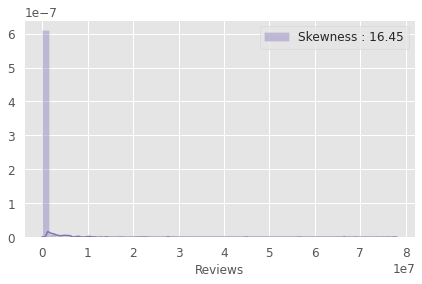

In [227]:
#check skewness for Reviews
g = sns.distplot(df["Reviews"], color="m", label="Skewness : %.2f"%(df["Reviews"].skew()))
g = g.legend(loc="best")

In [228]:
# Apply log transformation to reduce skewness distribution
df['Reviews_log'] = df['Reviews'].map(lambda i: np.log(i) if i > 0 else 0)


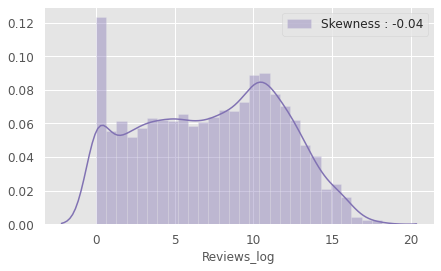

In [229]:
#check skewness for post log transformation on Reviews
g = sns.distplot(df["Reviews_log"], color="m", label="Skewness : %.2f"%(df["Reviews_log"].skew()))
g = g.legend(loc="best")

We can see skewness reduced to -0.04 

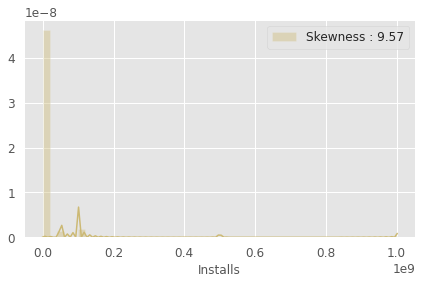

In [230]:
#check skewness for Installs
g = sns.distplot(df["Installs"], color="y", label="Skewness : %.2f"%(df["Installs"].skew()))
g = g.legend(loc="best")

In [231]:
# Apply log transformation to reduce skewness distribution
df['Installs_log'] = df['Installs'].map(lambda i: np.log(i) if i > 0 else 0)

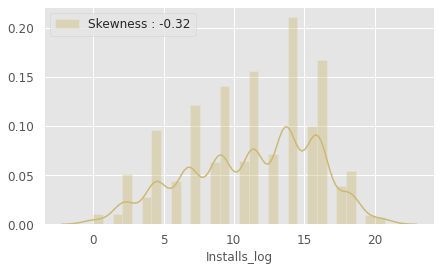

In [232]:
#check skewness for post log transformation on Installs
g = sns.distplot(df["Installs_log"], color="y", label="Skewness : %.2f"%(df["Installs_log"].skew()))
g = g.legend(loc="best")

Lets have a look at the cleaned data 

In [233]:
df.sample(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Reviews_log,Installs_log
3482,"Evernote – Organizer, Planner for Notes & Memos",PRODUCTIVITY,4.60000,1488396,999999.00000,100000000.00000,0,0.00000,Everyone,Productivity,"August 3, 2018",Varies with device,Varies with device,14.21321,18.42068
8046,ACTIVEON CX & CX GOLD,VIDEO_PLAYERS,3.30000,439,35000000.00000,50000.00000,0,0.00000,Everyone,Video Players & Editors,"March 4, 2016",0.7.9,4.0 and up,6.08450,10.81978
2142,Toy Guitar with songs for kids,FAMILY,4.30000,1369,9800000.00000,500000.00000,0,0.00000,Everyone,Music & Audio;Music & Video,"March 5, 2016",1.0.3,2.3 and up,7.22184,13.12236
1634,Real Estate by Movoto,LIFESTYLE,4.40000,3114,13000000.00000,100000.00000,0,0.00000,Everyone,Lifestyle,"February 20, 2018",6.1,4.0.3 and up,8.04366,11.51293
10068,Ex Service Taxis,BUSINESS,3.50000,15,8000000.00000,1000.00000,0,0.00000,Everyone,Business,"October 21, 2015",20.7.9.2,2.3 and up,2.70805,6.90776


Data cleaning completed

Step 2 : Exploratory Data analysis (EDA)

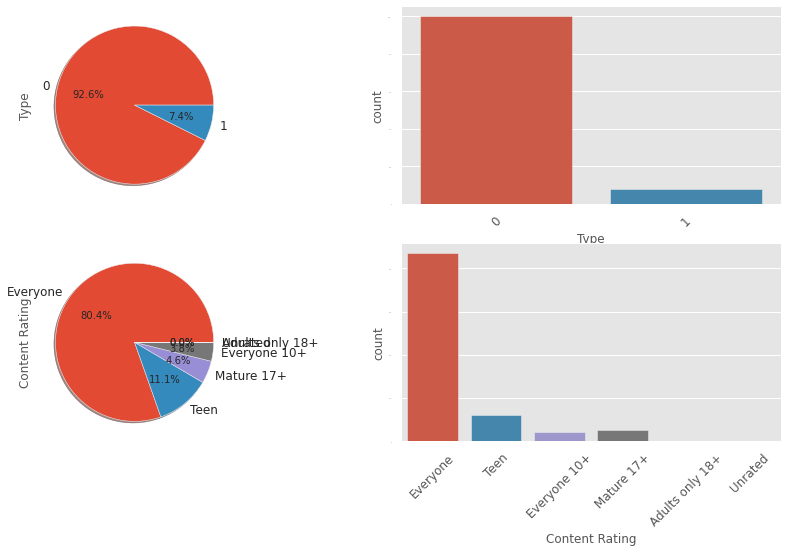

In [234]:
# Lets explore variables : 'Type','Content Rating' 
cat_col = ['Type','Content Rating']
plt.figure(figsize=(10, 12))
count = 1
for cols in cat_col:
    plt.subplot(2, 2, count)
    df[cols].value_counts().plot.pie(shadow=True,autopct='%1.1f%%')
    count +=1
    plt.subplot(2, 2, count)
    sns.countplot(cols, data=df)
    fig=plt.gcf()
    fig.set_size_inches(15,8)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=1)
    plt.xticks(rotation=45)
    count+=1

* Type : 92.6% apps are free Vs 7.4% are paid
* Content rating : 80.4% are for everyone 11.1% for teen, Adults only and unrated are 0%

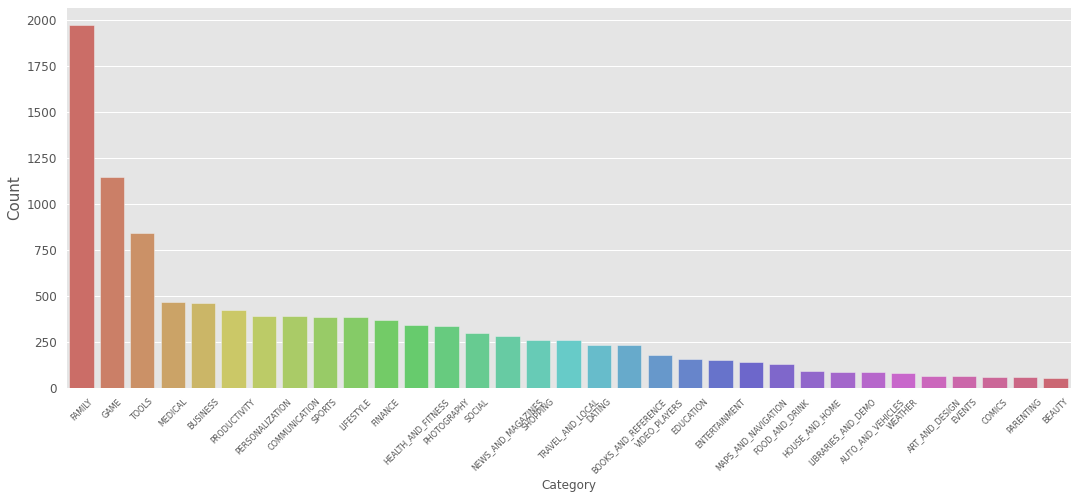

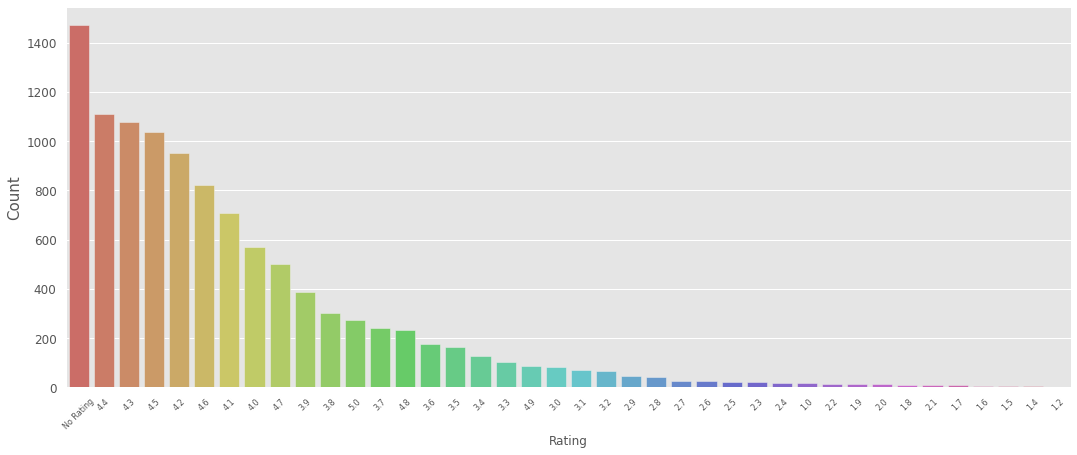

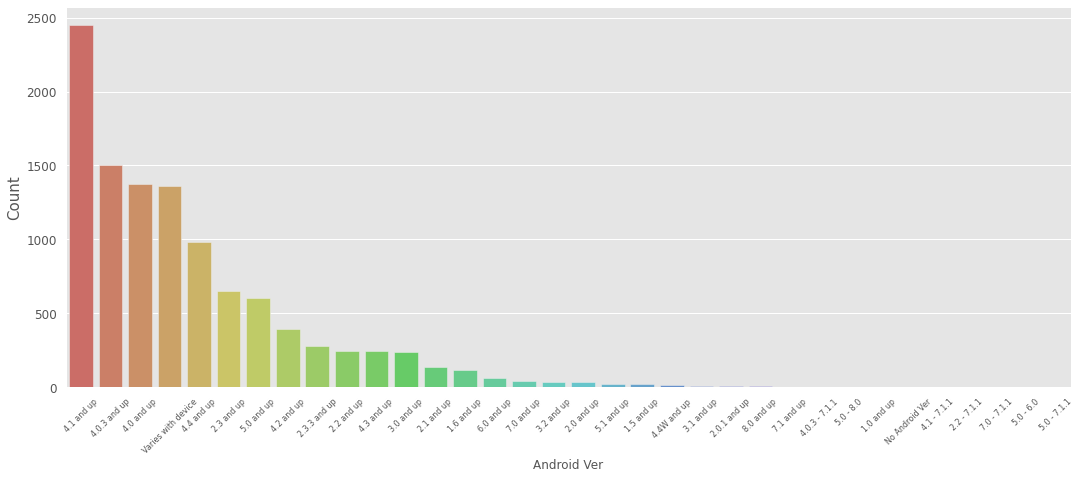

In [235]:
# Lets explore other categorical variables : 'Category', 'Rating', 'Android Ver'
cat_col_1 = ['Category', 'Rating', 'Android Ver']

for cols in cat_col_1:
    plt.figure(figsize=(18,7))
    sns.countplot(x=cols, order = df[cols].value_counts().index, data=df, palette="hls")
    plt.ylabel("Count", fontsize=15) # Seting the ytitle and size
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=12)
    plt.xticks(rotation=45)
    plt.show()

* Category :
    1. Family,Game & Tools Type Apps have highest count, whereas beauty, comics, parenting have lowest count.
    2. It means people are more concerned about Family and gaming apps which is as expected.
    3. Medical comes at No. 4.
    4. Dating apps count are above Education which is interesting
* Rating : "No rating is at top followed by "4.4,4.3 & 4.5 by count, 1.4, 1.5, 1.2 are lowest which means overall rating is good and peopl are happay about them.
* Android Ver: 4.1 version has highest count whereas 2.2.7.1.1. has lowest count, "Varies with device" is at no. 4 which is interesting ver. category

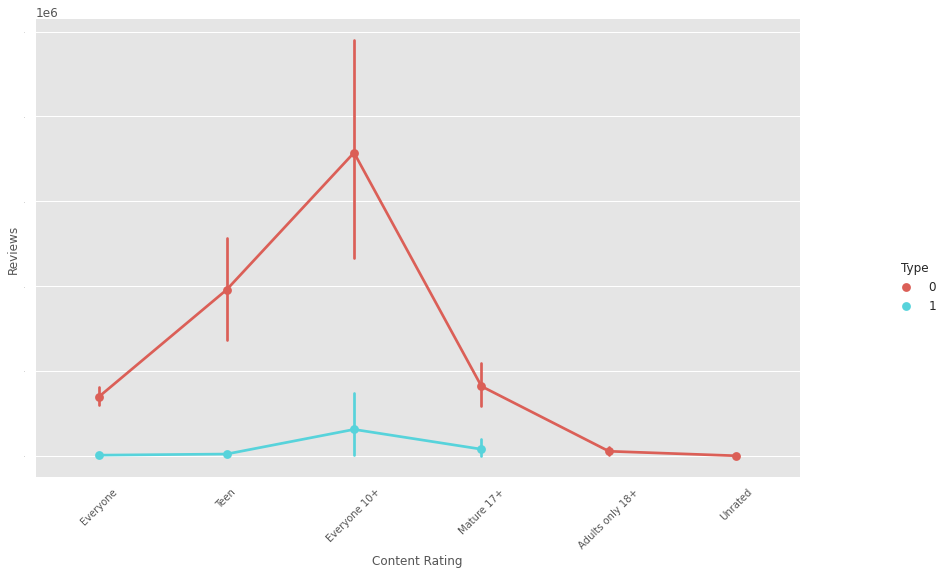

In [236]:
#Catplot Reviews+Content Rating+Type
sns.catplot(x='Content Rating',y='Reviews',kind='point',data=df,hue='Type', palette="hls")
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=1)
plt.xticks(rotation=45)
plt.show()

* No of reviews for free as well as paid apps are highest for "Everyone 10+"
* Under paid apps - "Mature 17+" content rating is at No. 2

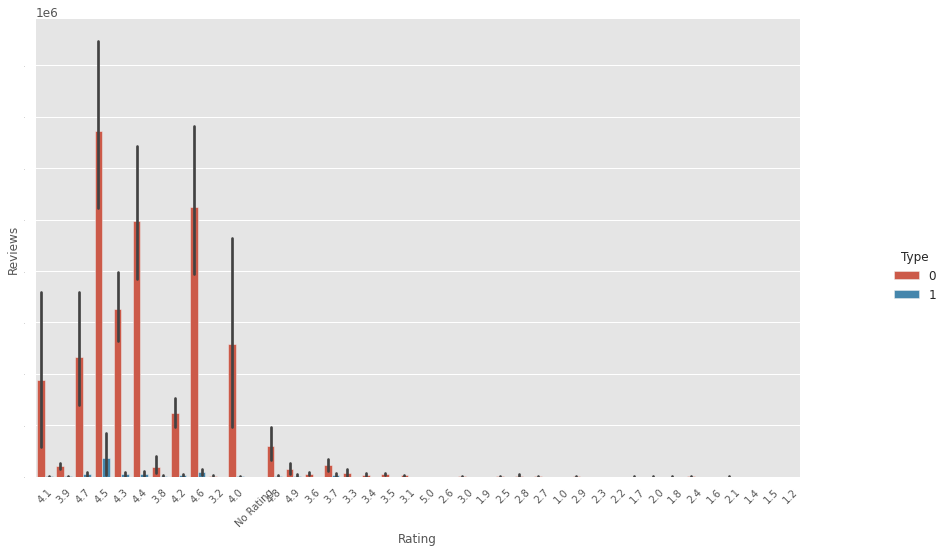

In [237]:
#Biveriate Analysis of Rating Vs reviews & hue= "Type"
sns.catplot(data=df, x='Rating', y='Reviews', kind='bar', hue="Type");
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=1)
plt.xticks(rotation=45)
plt.show()

Rating = 4.5 has got maximum no of reviews for free as well as paid apps
Rating = 4.6 stands at No. 2

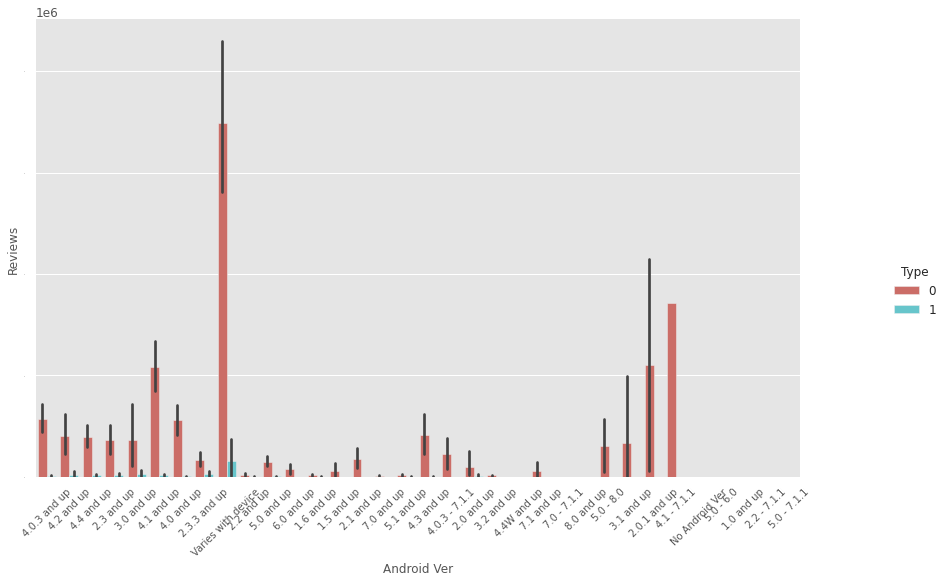

In [238]:
#Biveriate Analysis of Android Ver Vs reviews & hue="Type"
sns.catplot(data=df, x='Android Ver', y='Reviews', kind='bar', hue="Type", palette="hls");
fig=plt.gcf()
fig.set_size_inches(15,8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=1)
plt.xticks(rotation=45)
plt.show()

Android Ver = "Varies with device" has got maximum no of reviews in free as well as paid

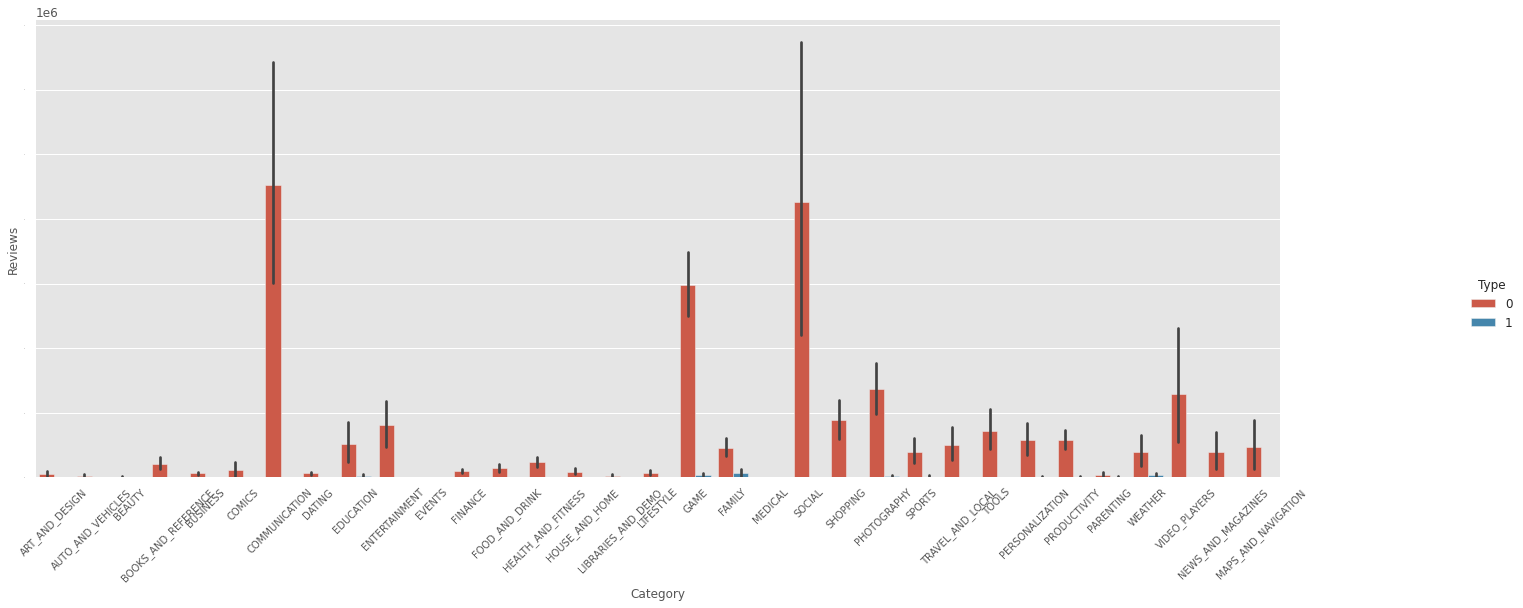

In [239]:
#Biveriate Analysis of Category Vs reviews & hue="Type"
sns.catplot(data=df, x='Category', y='Reviews', kind='bar', hue="Type");
fig=plt.gcf()
fig.set_size_inches(25,8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=1)
plt.xticks(rotation=45)
plt.show()

* Category = Social & communication have maximum reviews
* game and video player also have good amount of reviews
* Almost no reviews for Medical which is strange
* Most of the reviews are present for free apps
* Paid reviews are present for Game, weather and Family

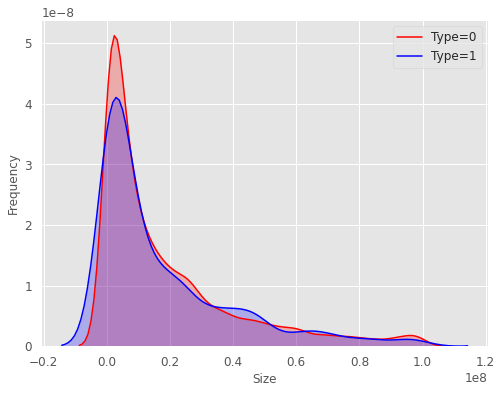

In [240]:
# Explore Size Vs Type using kde plots
plt.figure(figsize=(8, 6))
g = sns.kdeplot(df["Size"].round(5)[(df["Type"] == 0) & (df["Size"].notnull())], color="Red", shade = True)
g = sns.kdeplot(df["Size"].round(5)[(df["Type"] == 1) & (df["Size"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Size")
g.set_ylabel("Frequency")
g = g.legend(["Type=0","Type=1"])

Frequency of free reviews is slightly higher for low size than paid reviews

Lets do a correlation plot for entire dataframe 

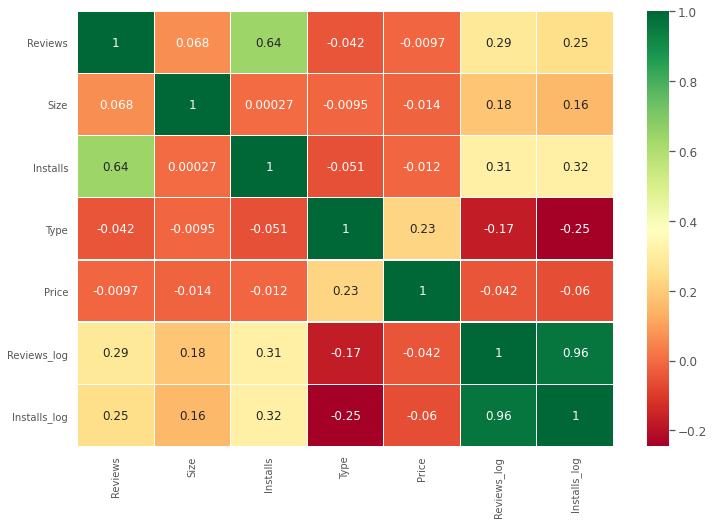

In [241]:
sns.heatmap(df.corr(),annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':12})
fig=plt.gcf()
fig.set_size_inches(12,8)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

* No of installs has strong positive correlation (0.64) with no of reviews which is kind of obvious
* Type is positively correlated with Typw i.e. As Type becomes 1 (paid), price increases

In [242]:
#Lets explore "Last Updated" i.e. Date field 
df['month'] = pd.DatetimeIndex(df['Last Updated']).month
df['weekday'] = pd.DatetimeIndex(df['Last Updated']).weekday
df.sample(5)

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver,Reviews_log,Installs_log,month,weekday
2649,"Mico- Stranger Chat Random video Chat, Live, Meet",SOCIAL,4.40000,624557,56000000.00000,10000000.00000,0,0.00000,Mature 17+,Social,"July 27, 2018",5.4.7.1,4.3 and up,13.34480,16.11810,7,4
3128,AirAsia,TRAVEL_AND_LOCAL,3.90000,98585,37000000.00000,10000000.00000,0,0.00000,Everyone,Travel & Local,"July 16, 2018",5.0.4,4.4 and up,11.49867,16.11810,7,0
9314,Equestria Girls,FAMILY,4.30000,392819,53000000.00000,10000000.00000,0,0.00000,Everyone,Role Playing;Action & Adventure,"July 22, 2016",37893,4.0 and up,12.88110,16.11810,7,4
9284,EF Summits,TRAVEL_AND_LOCAL,No Rating,0,19000000.00000,100.00000,0,0.00000,Everyone,Travel & Local,"May 20, 2018",1.1.3,4.4 and up,0.00000,4.60517,5,6
3939,Be A Legend: Soccer,SPORTS,3.80000,85763,21000000.00000,1000000.00000,0,0.00000,Everyone,Sports,"August 24, 2015",2.8.0.17,3.0 and up,11.35934,13.81551,8,0


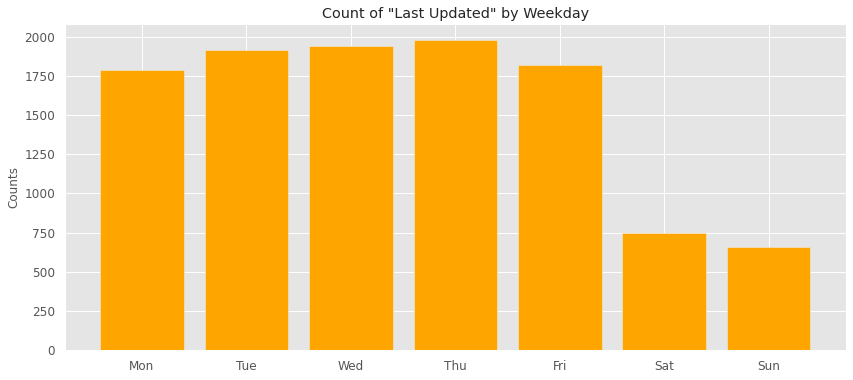

In [243]:
# Lets see how weekday analysis looks like
plt.rcParams['figure.figsize'] = (14,6)
df['weekday'].hist(bins=7,color='orange',range = (-.5,6.5),rwidth=.8)
plt.xticks(range(7),'Mon Tue Wed Thu Fri Sat Sun'.split());
plt.ylabel('Counts')
plt.title('Count of "Last Updated" by Weekday')
plt.show()

* Frequency of updates is way more on week days than week ends which is strange 
* It is highest on Thursday and lowest on Sunday

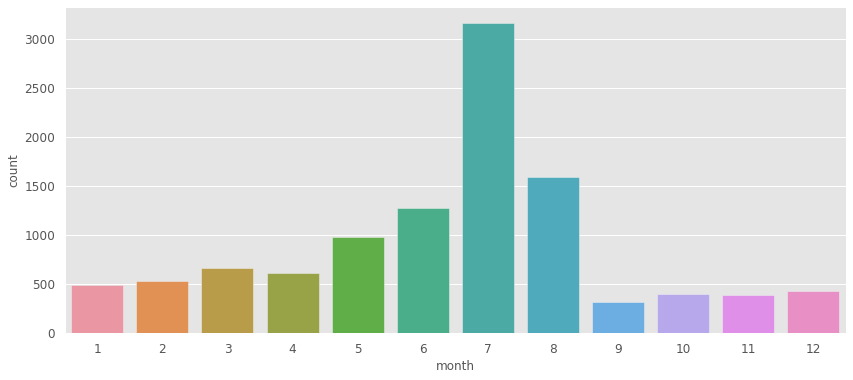

In [244]:
# Lets see how month analysis looks like
sns.countplot(x = 'month', data = df)

* July has highest updates against September whch has lowest. What can be the reason? Summer time ?  

In [245]:
#Creating an categorical variable to handle with the Price variable
interval = (-0.5, 0.5, 50.00, 300.00, 450.00)
cats = ['zero', 'low', 'medium', 'high',]
df["Price_cat"] = pd.cut(df.Price, interval, labels=cats)

In [246]:
df[["Price","Price_cat"]].sample(5)

,Price,Price_cat
2121,0.00000,zero
6870,0.00000,zero
5318,0.00000,zero
3721,0.00000,zero
938,0.00000,zero


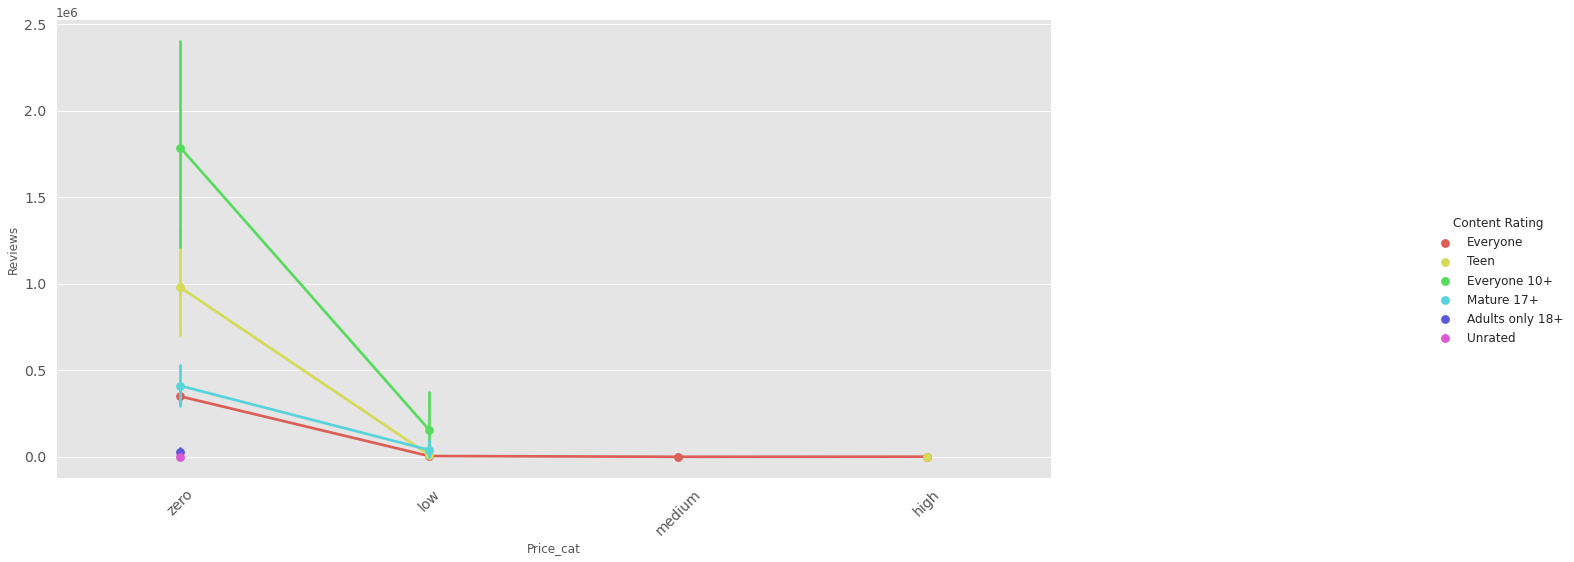

In [247]:
#Catplot Price_cat+Reviews+Content Rating
sns.catplot(x='Price_cat',y='Reviews',kind='point',data=df, palette="hls", hue="Content Rating")
fig=plt.gcf()
fig.set_size_inches(25,8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=45)
plt.show()

Most of the reviews are given for low zero price i.e. (Free apps)


In [248]:
#Creating an categorical variable to handle with the Size variable
interval = (8400, 100000, 1000000, 10000000, 1000000000)
cats = ['small', 'medium', 'high', 'Very high']
df["Size_cat"] = pd.cut(df.Size, interval, labels=cats)


In [249]:
df[["Size","Size_cat"]].sample(5)

,Size,Size_cat
4868,999999.00000,medium
6222,3600000.00000,high
8786,60000000.00000,Very high
10586,22000000.00000,Very high
10707,999999.00000,medium


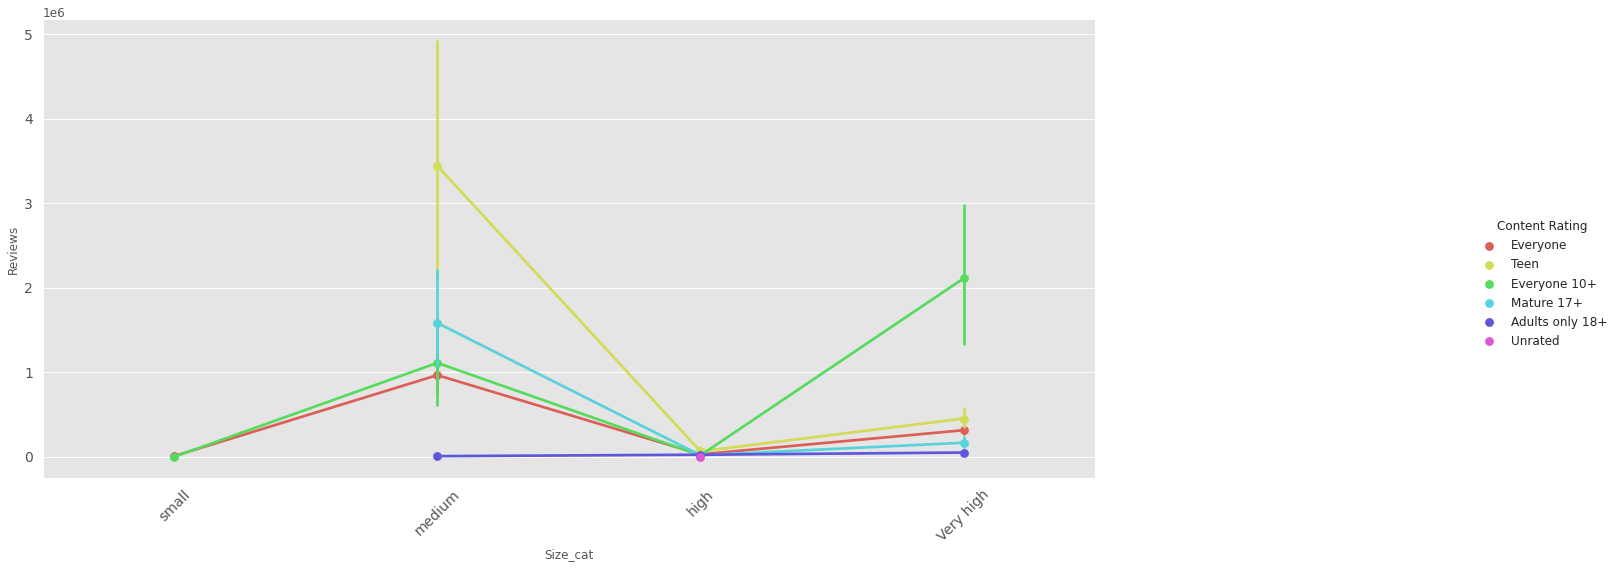

In [250]:
#Catplot Size_cat+Reviews+Content Rating
sns.catplot(x='Size_cat',y='Reviews',kind='point',data=df, palette="hls", hue="Content Rating")
fig=plt.gcf()
fig.set_size_inches(25,8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=45)
plt.show()


Medium size category are having highet no of reviews


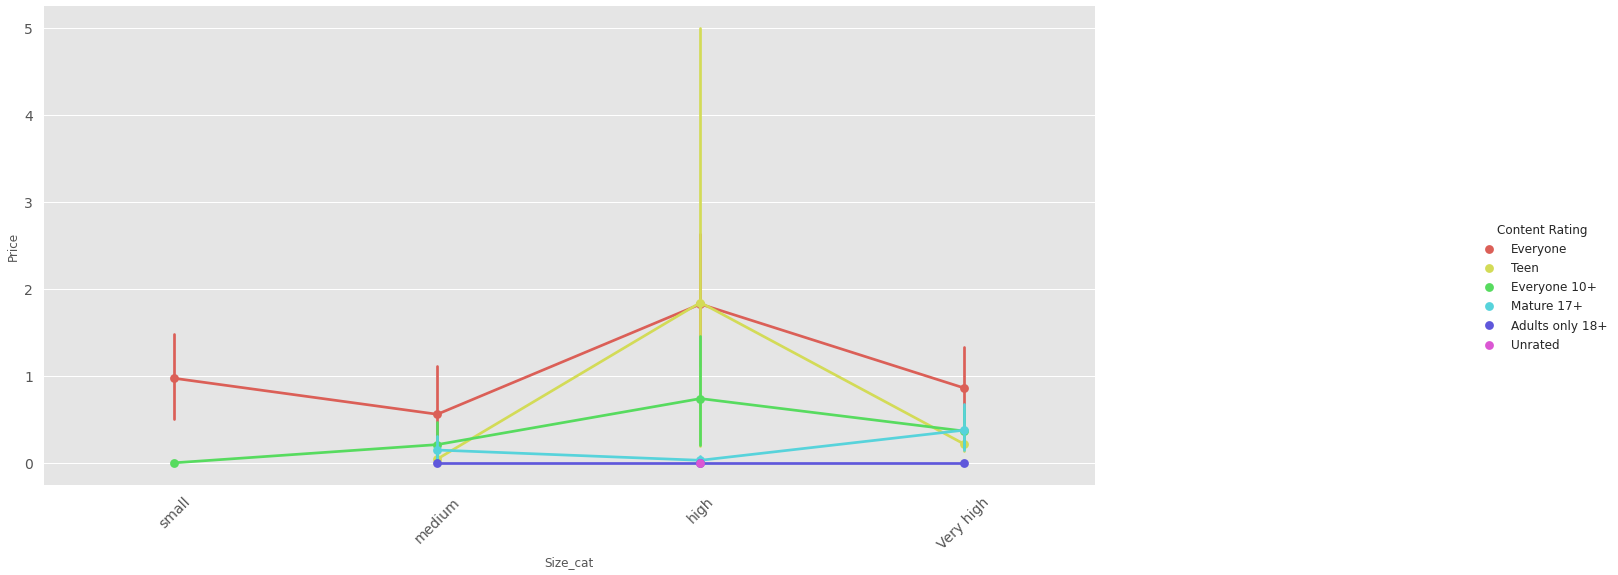

In [251]:
#Size_cat+Price+Content Rating
sns.catplot(x='Size_cat',y='Price',kind='point',data=df, palette="hls", hue="Content Rating")
fig=plt.gcf()
fig.set_size_inches(25,8)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=45)
plt.show()

* Apps with high size are having highest price
* teen content related apps are having high price under high size category 

> ****End of Part 1 :  EDA for "googleplaystore.csv" and draw insights from the data

Part 2 : Sentiment Analysis of the spreadsheet "googleplaystore_user_reviews.csv" and prediction

In [252]:
#Lets load the first csv file 
tweet = pd.read_csv('../input/google-play-store-apps/googleplaystore_user_reviews.csv')  

In [253]:
print('There are {} rows and {} columns'.format(tweet.shape[0],tweet.shape[1]))

There are 64295 rows and 5 columns


In [254]:
 tweet.sample(10)

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
58270,HBO NOW: Stream TV & Movies,NaN,NaN,nan,nan
35664,"Domofond Недвижимость. Купить, снять квартиру.",The idea with the designation of the area wher...,Positive,0.17333,0.44310
27083,Clash of Clans,NaN,NaN,nan,nan
24027,Canvas Student,NaN,NaN,nan,nan
9149,Arrow.io,Simple fun game,Negative,-0.03333,0.31905
30064,Cover Fire: offline shooting games for free,NaN,NaN,nan,nan
34358,DigiCal Calendar Agenda,I bunch different calendars (different events ...,Negative,-0.07000,0.37000
23188,Candy Bomb,Love game,Positive,0.05000,0.50000
62226,"Hily: Dating, Chat, Match, Meet & Hook up",Hello I would like delete profile charge money...,Positive,0.20000,0.20000
46329,Fishdom,I LOVE WHEN THE FISH TALK & CARRY ON A CONVERS...,Positive,0.18929,0.65429


* We can see there are NAN values for aall four columns (Translated_Review,sentiment, sentiment polarity, sentiment subjetivity)on multiple rows. 
* Let see missing values in entire dataframe

In [255]:
#Lets check Missing values
tweet.isna().sum()

App                           0
Translated_Review         26868
Sentiment                 26863
Sentiment_Polarity        26863
Sentiment_Subjectivity    26863
dtype: int64

In [256]:
#Lets see % wise top contributors to missing values 
def missing_values(dff):
    print (round((dff.isnull().sum() * 100/ len(dff)),2).sort_values(ascending=False))
missing_values(tweet)

Translated_Review        41.79000
Sentiment_Subjectivity   41.78000
Sentiment_Polarity       41.78000
Sentiment                41.78000
App                       0.00000
dtype: float64


41% (i.e. 26863 out of 64295) of the data in four columns is missing 

* Lets delete the missing values if all four columns 
* (Translated_Review,sentiment, sentiment polarity, sentiment subjetivity)are having null values using thresh
i.e. Lets delete the missing values if no of Null values > 1 in a row

In [257]:
tweet.dropna(thresh=2, inplace=True) 

26863 rows deleted

In [258]:
#Lets check Missing values
tweet.isna().sum()

App                       0
Translated_Review         5
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

Still 5 missing values in column Translated review

In [259]:
#Display remaining Null values 
tweet[tweet.isna().any(axis=1)]

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
268,11st,NaN,Neutral,0.00000,0.00000
15048,Birds Sounds Ringtones & Wallpapers,NaN,Neutral,0.00000,0.00000
22092,Calorie Counter - MyFitnessPal,NaN,Neutral,0.00000,0.00000
31623,DC Comics,NaN,Neutral,0.00000,0.00000
52500,Garden Photo Frames - Garden Photo Editor,NaN,Neutral,0.00000,0.00000


Lets inject text = "Neutral" for Sentiment="Neutral"

In [260]:
#Lets inject text = "Neutral" for Sentiment="Neutral"
tweet.loc[(tweet.Translated_Review.isnull()),'Translated_Review'] ='Neutral'

In [261]:
#Lets check Missing values
tweet.isna().sum()

App                       0
Translated_Review         0
Sentiment                 0
Sentiment_Polarity        0
Sentiment_Subjectivity    0
dtype: int64

No missing values , Lets begin with EDA

In [262]:
print('There are {} rows and {} columns in tweet'.format(tweet.shape[0],tweet.shape[1]))

There are 37432 rows and 5 columns in tweet


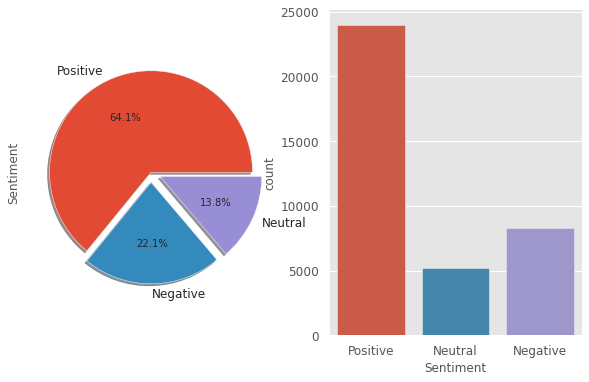

In [263]:
#Explore Categorical Variable - Sentiment
cat_col = ['Sentiment']
plt.figure(figsize=(10, 6))
count = 1
for cols in cat_col:
    plt.subplot(1, 2, count)
    tweet[cols].value_counts().plot.pie(explode=[0,0.1,0.1],shadow=True,autopct='%1.1f%%')
    count +=1
    plt.subplot(1, 2, count)
    sns.countplot(cols, data=tweet)
    count+=1

In [264]:
tweet['Sentiment'].value_counts()

Positive    23998
Negative     8271
Neutral      5163
Name: Sentiment, dtype: int64

* Overall Sentiment is Positive  
* 64.1% (23998) sentiment is positive
* 22.1% (8271) is negative
* 13.8% (5163) is Neutral

Lets explore numerical variables - Sentiment_Polarity & Sentiment_Subjectivity

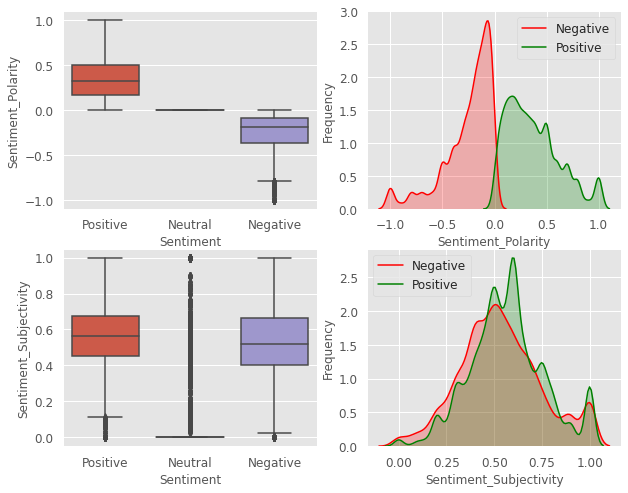

In [265]:
#Lets explore numerical variables - Sentiment_Polarity & Sentiment_Subjectivity
num_col = ['Sentiment_Polarity', 'Sentiment_Subjectivity']

plt.figure(figsize=(10, 8))
count = 1
for cols in num_col:
    plt.subplot(2, 2, count)
    sns.boxplot(x='Sentiment', y= cols, data= tweet)
    count +=1
    
    plt.subplot(2, 2, count)
    g = sns.kdeplot(tweet[cols][(tweet["Sentiment"] == "Negative") & (tweet[cols].notnull())], color="Red", shade = True)
    g = sns.kdeplot(tweet[cols][(tweet["Sentiment"] == "Positive") & (tweet[cols].notnull())], ax =g, color="Green", shade= True)
    g.set_xlabel(cols)
    g.set_ylabel("Frequency")
    g = g.legend(["Negative","Positive"])
    count+=1

1. Sentiment_Polarity :
    * For positive - review polarity is highest (median : 0.37)
    * For Negative - review polarity is lowest  (median : -0.12)
    * For Neutral  - Its  0
2. Sentiment_Subjectivity :
    * For positive - review polarity is higher (median : 0.58)
    * For Negative - review polarity is slightly lower than positive  (median : 0.55)
    * For Neutral  - Many outliers can be seen

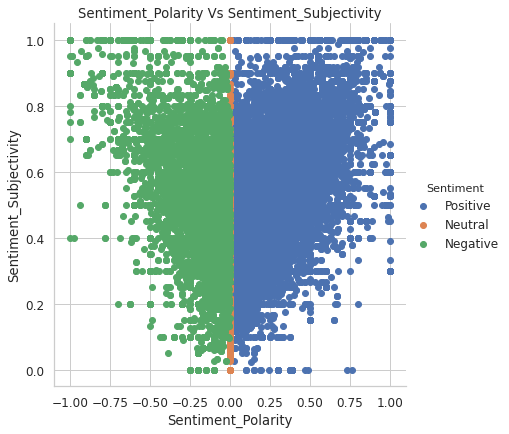

In [266]:
# Scattrplot between Sentiment_Polarity Vs Sentiment_Subjectivity with hue= sentiment
sns.set(style='whitegrid', palette="deep", font_scale=1.1, rc={"figure.figsize": [5, 3]})
(sns
 .FacetGrid(tweet, hue='Sentiment', size=6)
 .map(plt.scatter, 'Sentiment_Polarity', 'Sentiment_Subjectivity')
 .add_legend()
 .set(
    title='Sentiment_Polarity Vs Sentiment_Subjectivity',
    xlabel='Sentiment_Polarity',
    ylabel='Sentiment_Subjectivity'
))

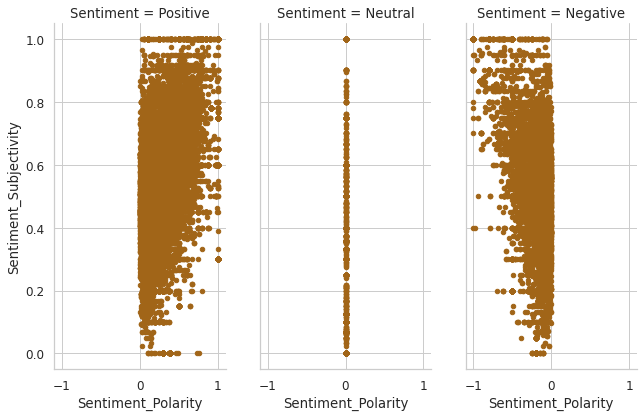

In [267]:
# Separate scatter plots for Sentiment_Polarity Vs Sentiment_Subjectivity across varous sentiments
sns.set(style='whitegrid', palette="BrBG", font_scale=1.1, rc={"figure.figsize": [7, 4]})
(tweet
 .pipe(sns.FacetGrid, 
       col='Sentiment', 
       col_wrap=4, 
       aspect=.5, 
       size=6)
 .map(plt.scatter, 'Sentiment_Polarity', 'Sentiment_Subjectivity', s=20)
 .fig.subplots_adjust(wspace=.2, hspace=.2)
)

A Clear separation among positive, negative and neutral can be seen

Text(0.5, 1.0, 'Count of top 15 Apps')

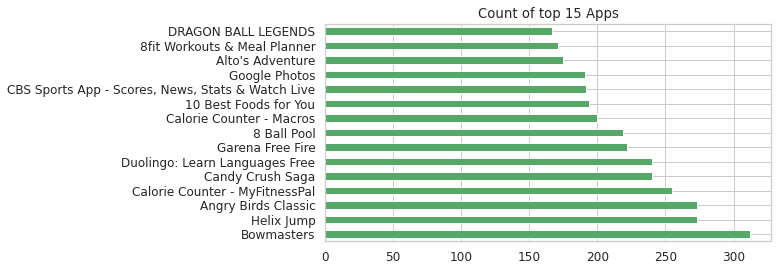

In [268]:
#Explore variable  - App - Top 15
plt.figure(figsize=(8, 4))
tweet['App'].value_counts()[0:15].plot.barh(color="g").set_title('Count of top 15 Apps')

Bowmasters app is at the top

Text(0.5, 1.0, 'Count of bottom 15 Apps')

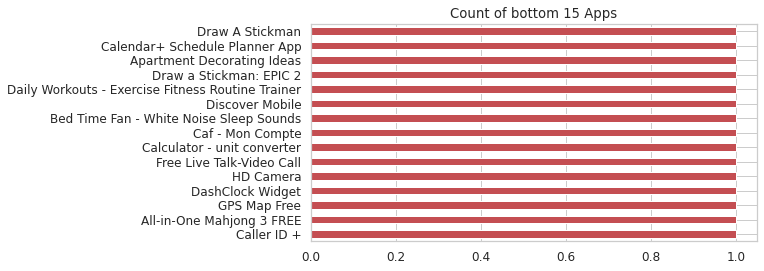

In [269]:
#Explore variable  - App - Bottom 15
plt.figure(figsize=(8, 4))
tweet['App'].value_counts()[-15:].plot.barh(color="r").set_title('Count of bottom 15 Apps')

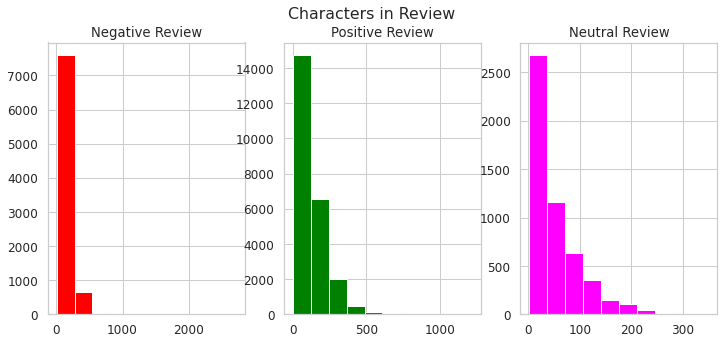

In [270]:
#Explore Variable - Translated_Review
#Number of characters in tweets
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(12,5))
tweet_len=tweet[tweet['Sentiment']=='Negative']['Translated_Review'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('Negative Review')
tweet_len=tweet[tweet['Sentiment']=='Positive']['Translated_Review'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Positive Review')
tweet_len=tweet[tweet['Sentiment']=='Neutral']['Translated_Review'].str.len()
ax3.hist(tweet_len,color='magenta')
ax3.set_title('Neutral Review')
fig.suptitle('Characters in Review')
plt.show()

* Negative : 0-250 character length observed for 7500+ reviews
* Positive : 0-125 character length observed for 14000+ reviews
* Neutral  : 0-30 character length observed for 2700+ reviews

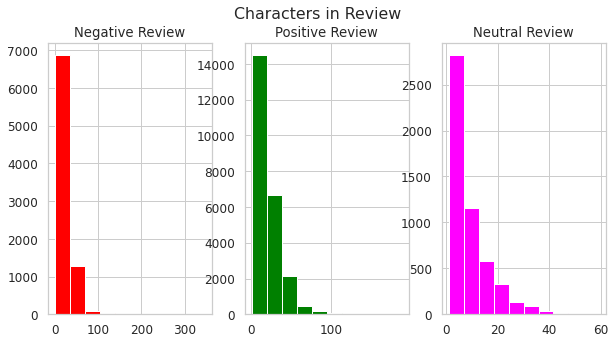

In [271]:
#Number of words in a Reviews
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))
tweet_len_neg=tweet[tweet['Sentiment']=='Negative']['Translated_Review'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len_neg,color='red')
ax1.set_title('Negative Review')
tweet_len_pos=tweet[tweet['Sentiment']=='Positive']['Translated_Review'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len_pos,color='green')
ax2.set_title('Positive Review')
tweet_len_neutral=tweet[tweet['Sentiment']=='Neutral']['Translated_Review'].str.split().map(lambda x: len(x))
ax3.hist(tweet_len_neutral,color='magenta')
ax3.set_title('Neutral Review')
fig.suptitle('Characters in Review')
plt.show()

* Negative : 0-30 word length observed for 6900+ reviews
* Positive : 0-20 word length observed for 14200+ reviews
* Neutral  : 0-6 word length observed for 2700+ reviews

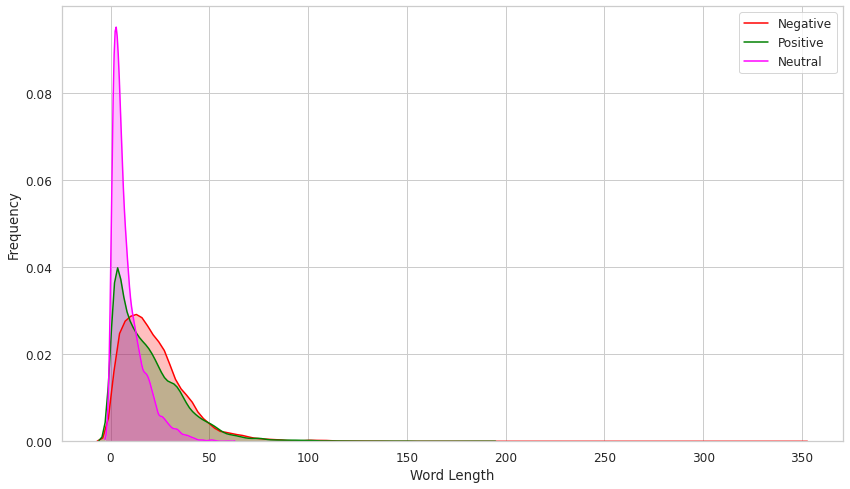

In [272]:
# Explore length of reviews Vs Sentiment using kde plots
plt.figure(figsize=(14, 8))
g = sns.kdeplot(tweet_len_neg, color="Red", shade = True)
g = sns.kdeplot(tweet_len_pos, ax =g, color="Green", shade= True)
g = sns.kdeplot(tweet_len_neutral, ax =g, color="magenta", shade= True)

g.set_xlabel("Word Length")
g.set_ylabel("Frequency")
g = g.legend(["Negative","Positive","Neutral"])

In Overlapping kde plot - we can see that the density is higher for neutral for length (0-25)

Text(0.5, 0.98, 'Average word length in each review')

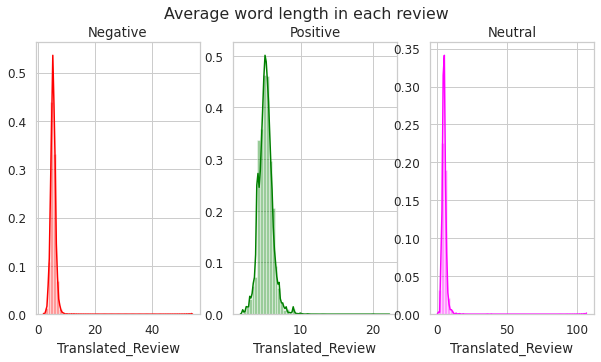

In [273]:
#Average word length in a review
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(10,5))
word=tweet[tweet['Sentiment']=='Negative']['Translated_Review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Negative')
word=tweet[tweet['Sentiment']=='Positive']['Translated_Review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Positive')
word=tweet[tweet['Sentiment']=='Neutral']['Translated_Review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax3,color='magenta')
ax3.set_title('Neutral')
fig.suptitle('Average word length in each review')

Average word length more for positive than other categories

<BarContainer object of 10 artists>

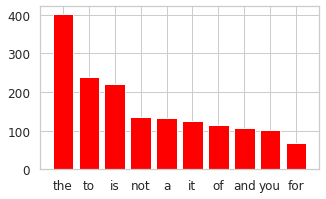

In [274]:
#Common stopwords in reviews - First we will analyze review with class Negative
def create_corpus(target):
    corpus=[]
    
    for x in tweet[tweet['Sentiment']==target]['Translated_Review'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus=create_corpus("Negative")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.figure(figsize=(5, 3))
plt.bar(x,y,color="red")

<BarContainer object of 10 artists>

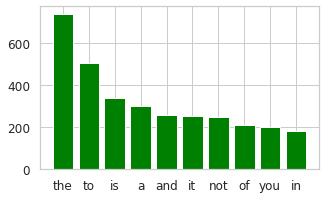

In [275]:
#Lets analyze review with class Positive
corpus=create_corpus("Positive")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.figure(figsize=(5, 3))
plt.bar(x,y,color="green")

<BarContainer object of 10 artists>

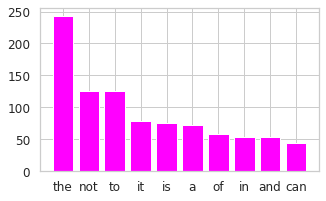

In [276]:
#Lets analyze review with class Neutral
corpus=create_corpus("Neutral")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

x,y=zip(*top)
plt.figure(figsize=(5, 3))
plt.bar(x,y,color="magenta")

<BarContainer object of 21 artists>

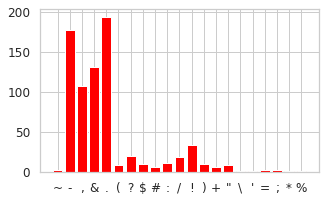

In [277]:
#Analyzing punctuations - Lets check class Negative
plt.figure(figsize=(5,3))
corpus=create_corpus("Negative")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color="red")

<BarContainer object of 27 artists>

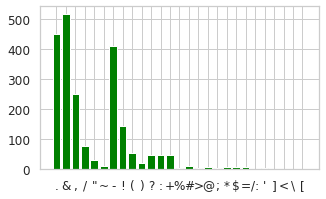

In [278]:
#Analyzing punctuations - Lets check class Positive
plt.figure(figsize=(5,3))
corpus=create_corpus("Positive")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color="green")

<BarContainer object of 19 artists>

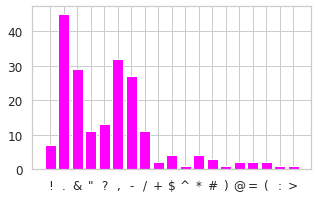

In [279]:
#Analyzing punctuations - Lets check class Neutral
plt.figure(figsize=(5,3))
corpus=create_corpus("Neutral")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color="magenta")

In [280]:
def create_corpus_generic():
    corpus=[]
    
    for x in tweet['Translated_Review'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

corpus_generic=create_corpus_generic()


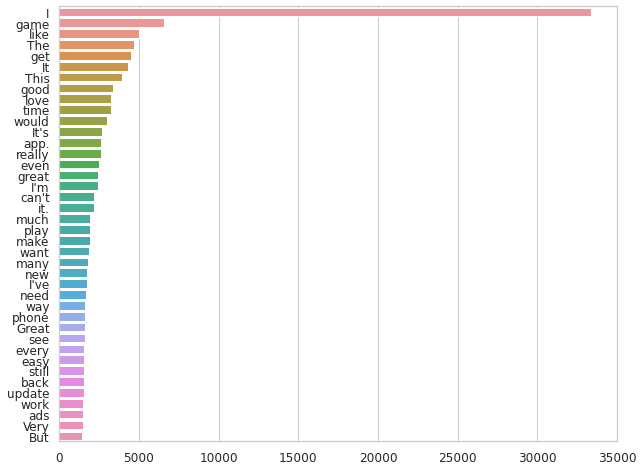

In [281]:
# Identify common words in generic corpus
counter=Counter(corpus_generic)
most=counter.most_common()

x=[]
y=[]

for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)
plt.figure(figsize=(10,8))
sns.barplot(x=y,y=x)

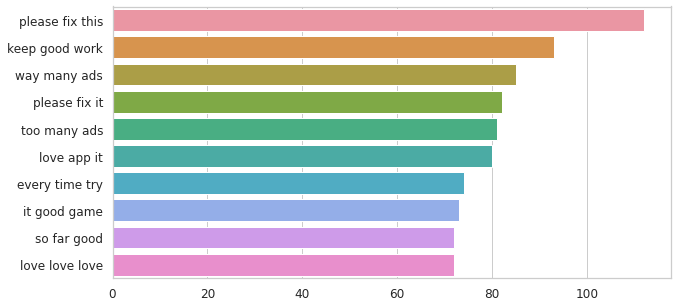

In [282]:
#Ngram analysis
#we will do a bigram (n=2) analysis over the tweets.
#Let's check the most common bigrams in tweets.
def get_top_tweet_bigrams(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

plt.figure(figsize=(10,5))
top_tweet_bigrams=get_top_tweet_bigrams(tweet['Translated_Review'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
sns.barplot(x=y,y=x)

Data Cleaning starts

In [283]:
#Step 1 : Removing urls

def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

tweet['tweet_NoURL']=tweet['Translated_Review'].apply(lambda x : remove_URL(x))
tweet[['tweet_NoURL']].head(10)


,tweet_NoURL
0,I like eat delicious food. That's I'm cooking ...
1,This help eating healthy exercise regular basis
3,Works great especially going grocery store
4,Best idea us
5,Best way
6,Amazing
8,"Looking forward app,"
9,It helpful site ! It help foods get !
10,good you.
11,Useful information The amount spelling errors ...


In [284]:
#Step 2 : Removing HTML tags

tweet['tweet_NoURL']=tweet['tweet_NoURL'].apply(str)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

tweet['tweet_NoHTML']=tweet['tweet_NoURL'].apply(lambda x : remove_html(x))
tweet['tweet_NoHTML'].head(10)

0     I like eat delicious food. That's I'm cooking ...
1       This help eating healthy exercise regular basis
3            Works great especially going grocery store
4                                          Best idea us
5                                              Best way
6                                               Amazing
8                                  Looking forward app,
9                 It helpful site ! It help foods get !
10                                            good you.
11    Useful information The amount spelling errors ...
Name: tweet_NoHTML, dtype: object

In [285]:
#Step 3 : Romoving Emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

tweet['tweet_NoEMOJI']=tweet['tweet_NoHTML'].apply(lambda x: remove_emoji(x))
tweet[['tweet_NoURL','tweet_NoHTML','tweet_NoEMOJI']].head(10)

,tweet_NoURL,tweet_NoHTML,tweet_NoEMOJI
0,I like eat delicious food. That's I'm cooking ...,I like eat delicious food. That's I'm cooking ...,I like eat delicious food. That's I'm cooking ...
1,This help eating healthy exercise regular basis,This help eating healthy exercise regular basis,This help eating healthy exercise regular basis
3,Works great especially going grocery store,Works great especially going grocery store,Works great especially going grocery store
4,Best idea us,Best idea us,Best idea us
5,Best way,Best way,Best way
6,Amazing,Amazing,Amazing
8,"Looking forward app,","Looking forward app,","Looking forward app,"
9,It helpful site ! It help foods get !,It helpful site ! It help foods get !,It helpful site ! It help foods get !
10,good you.,good you.,good you.
11,Useful information The amount spelling errors ...,Useful information The amount spelling errors ...,Useful information The amount spelling errors ...


In [286]:
#Step 4 :Removing punctuations
def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

tweet['tweet_NoPUNKT']=tweet['tweet_NoEMOJI'].apply(lambda x : remove_punct(x))
tweet[['tweet_NoURL','tweet_NoHTML','tweet_NoEMOJI','tweet_NoPUNKT']].head(10)

,tweet_NoURL,tweet_NoHTML,tweet_NoEMOJI,tweet_NoPUNKT
0,I like eat delicious food. That's I'm cooking ...,I like eat delicious food. That's I'm cooking ...,I like eat delicious food. That's I'm cooking ...,I like eat delicious food Thats Im cooking foo...
1,This help eating healthy exercise regular basis,This help eating healthy exercise regular basis,This help eating healthy exercise regular basis,This help eating healthy exercise regular basis
3,Works great especially going grocery store,Works great especially going grocery store,Works great especially going grocery store,Works great especially going grocery store
4,Best idea us,Best idea us,Best idea us,Best idea us
5,Best way,Best way,Best way,Best way
6,Amazing,Amazing,Amazing,Amazing
8,"Looking forward app,","Looking forward app,","Looking forward app,",Looking forward app
9,It helpful site ! It help foods get !,It helpful site ! It help foods get !,It helpful site ! It help foods get !,It helpful site It help foods get
10,good you.,good you.,good you.,good you
11,Useful information The amount spelling errors ...,Useful information The amount spelling errors ...,Useful information The amount spelling errors ...,Useful information The amount spelling errors ...


> ****If you have liked my Kernel, PLEASE UPVOTE

In [287]:
#Step 5: transform to lowercase
tweet['tweet_tolower']= tweet['tweet_NoPUNKT'].str.lower()
tweet[['tweet_NoPUNKT','tweet_tolower']].head(10)

,tweet_NoPUNKT,tweet_tolower
0,I like eat delicious food Thats Im cooking foo...,i like eat delicious food thats im cooking foo...
1,This help eating healthy exercise regular basis,this help eating healthy exercise regular basis
3,Works great especially going grocery store,works great especially going grocery store
4,Best idea us,best idea us
5,Best way,best way
6,Amazing,amazing
8,Looking forward app,looking forward app
9,It helpful site It help foods get,it helpful site it help foods get
10,good you,good you
11,Useful information The amount spelling errors ...,useful information the amount spelling errors ...


In [288]:
#Step 6: remove stopwords 'n punctuation
sw = stopwords.words('english')

def transform_text(s):
    
    # remove html
    html=re.compile(r'<.*?>')
    s = html.sub(r'',s)
    
    # remove numbers
    s = re.sub(r'\d+', '', s)
    
    # remove punctuation
    # remove stopwords
    tokens = nltk.word_tokenize(s)
    
    new_string = []
    for w in tokens:
        # remove words with len = 2 AND stopwords
        if len(w) > 2 and w not in sw:
            new_string.append(w)
 
    s = ' '.join(new_string)
    s = s.strip()

    exclude = set(string.punctuation)
    s = ''.join(ch for ch in s if ch not in exclude)
    
    return s.strip()

tweet['tweet_sw'] = tweet['tweet_tolower'].apply(transform_text)
tweet[['tweet_NoPUNKT','tweet_tolower', 'tweet_sw']].head(10)

,tweet_NoPUNKT,tweet_tolower,tweet_sw
0,I like eat delicious food Thats Im cooking foo...,i like eat delicious food thats im cooking foo...,like eat delicious food thats cooking food cas...
1,This help eating healthy exercise regular basis,this help eating healthy exercise regular basis,help eating healthy exercise regular basis
3,Works great especially going grocery store,works great especially going grocery store,works great especially going grocery store
4,Best idea us,best idea us,best idea
5,Best way,best way,best way
6,Amazing,amazing,amazing
8,Looking forward app,looking forward app,looking forward app
9,It helpful site It help foods get,it helpful site it help foods get,helpful site help foods get
10,good you,good you,good
11,Useful information The amount spelling errors ...,useful information the amount spelling errors ...,useful information amount spelling errors ques...


In [289]:

#Step 7: lemmatizer

lemmatizer = WordNetLemmatizer()
def lemmatizer_text(s):
    tokens = nltk.word_tokenize(s)
    
    new_string = []
    for w in tokens:
        lem = lemmatizer.lemmatize(w, pos="v")
        # exclude if lenght of lemma is smaller than 2
        if len(lem) > 2:
            new_string.append(lem)
    
    s = ' '.join(new_string)
    return s.strip()


tweet['tweet_lm'] = tweet['tweet_sw'].apply(lemmatizer_text)


In [290]:
#Step 8: transform to lowercase, select only alphabets and remove stopwords
def create_corpus(df):
    corpus=[]
    #corpus_new=[]
    for tweet in tqdm(df['tweet_lm']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word.lower() not in stop))]
        corpus.append(words)
        #words_new = (word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word.lower() not in stop)))
        #corpus_new.append(words_new)
    return corpus

corpus=create_corpus(tweet)

100%|██████████| 37432/37432 [00:08<00:00, 4245.06it/s]


In [291]:
#Find max length of a row in the corpus
MAX_LEN = max(len(x) for x in corpus)
print("MAX_LEN = ", MAX_LEN)

MAX_LEN =  289


Text processing completed

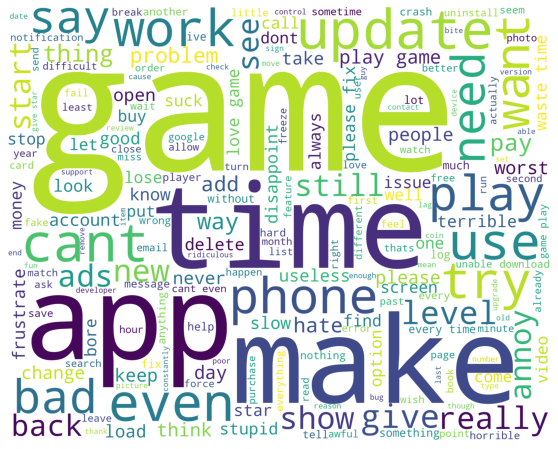

In [292]:
#see the word cloud with treated text
# -ve wordcloud
df_neg = tweet[tweet['Sentiment']=="Negative"]['tweet_lm']

wordcloud1 = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_neg))

plt.figure(1,figsize=(10, 8))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()



Negative  words like waste time, bad, hate, frustrate can be seen

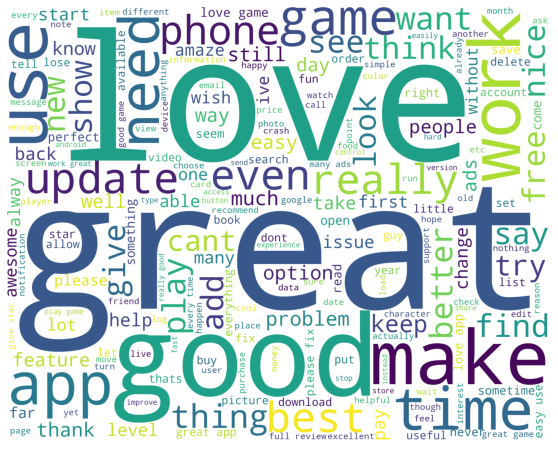

In [293]:
# +ve wordcloud
df_pos = tweet[tweet['Sentiment']=="Positive"]['tweet_lm']


wordcloud1 = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_pos))

plt.figure(1,figsize=(10, 8))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()

Positive words like great, good, love, best, better, tanks ,amaze can be seen

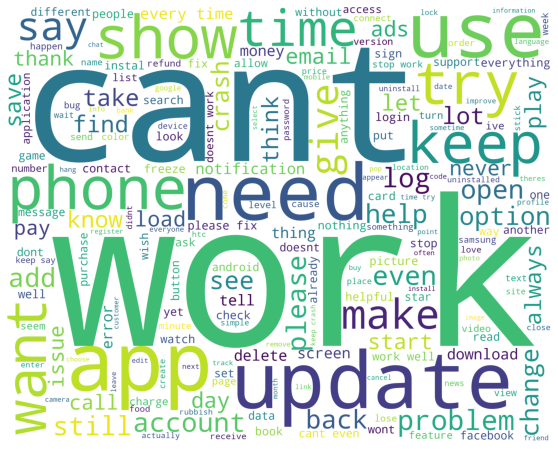

In [294]:
# Neutral wordcloud
df_neu = tweet[tweet['Sentiment']=="Neutral"]['tweet_lm']


wordcloud1 = WordCloud(stopwords=STOPWORDS,
                      background_color='white',
                      width=2500,
                      height=2000
                      ).generate(" ".join(df_neu))

plt.figure(1,figsize=(10, 8))
plt.imshow(wordcloud1)
plt.axis('off')
plt.show()


Neutral  words like work, need, use app, keep can be seen

In [295]:
#label encode the target variable
label_encoder = LabelEncoder()
tweet['sentiment_encoded'] = label_encoder.fit_transform(tweet['Sentiment'])


x = tweet['tweet_lm'].values
y = tweet['sentiment_encoded'].values

X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (31817,)
Shape of Validation  (5615,)


Approach - 1 : Classical SGD Algorithm 

In [296]:
#Vectorize the data
vectorizer = CountVectorizer(binary=False, ngram_range=(1, 2))
#vectorizer = TfidfVectorizer(binary=True, ngram_range=(1, 2))
vectorizer.fit(X_train)
X_train_onehot = vectorizer.transform(X_train)
X_test_onehot = vectorizer.transform(X_test)

#print shape post encoding 
print(X_train_onehot.shape)
print(X_test_onehot.shape)

(31817, 221719)
(5615, 221719)


In [297]:
# Generic function for model building
def fit_and_test(classifier, X_train, y_train, X_test, y_test, only_return_accuracy=False):
  classifier.fit(X_train, y_train)
  y_hat = classifier.predict(X_test)
  print('accuracy:', accuracy_score(y_test, y_hat))
  if not only_return_accuracy:
    print('f1_score:', f1_score(y_test, y_hat,average='micro'))

In [298]:
#SGDRegressor
sgd = SGDClassifier() # 92.19%
fit_and_test(sgd, X_train_onehot, y_train, X_test_onehot, y_test)


accuracy: 0.9228851291184328
f1_score: 0.9228851291184328


> ****We achieved 92.23% accuracy with classical SGD algorithm

Approach - 2 : Simple Neural Networks, N-gram=(1,2) and using TfidfVectorizer with Top 30k features

In [299]:
from sklearn.feature_extraction.text import CountVectorizer
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
NGRAM_RANGE = (1, 2)
TOP_K = 30000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 1

def ngram_vectorize(texts, labels):
    kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ,
    }
    # Learn Vocab from train texts and vectorize train and val sets
    tfidf_vectorizer = TfidfVectorizer(**kwargs)
    transformed_texts = tfidf_vectorizer.fit_transform(texts)
    
    print("Size of vocabulary = ", transformed_texts.shape[1]) #will have size of vocaulary
    
    # Select best k features, with feature importance measured by f_classif
    # Set k as 20000 or (if number of ngrams is less) number of ngrams   
    selector = SelectKBest(f_classif, k=min(TOP_K, transformed_texts.shape[1]))
    selector.fit(transformed_texts, labels)
    transformed_texts = selector.transform(transformed_texts).astype('float32')
    return transformed_texts


# Vectorize the data

vect_data = ngram_vectorize(tweet['tweet_lm'], tweet['sentiment_encoded'])

vect_data.shape[0]

X = vect_data.toarray()
y = (np.array(tweet['sentiment_encoded']))

# Here we split data to training and testing parts
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=13)
print("Train dataset shape: {0}, \nTest dataset shape: {1}".format(X_train.shape, X_test.shape))



Size of vocabulary =  246447
Train dataset shape: (29945, 30000), 
Test dataset shape: (7487, 30000)


In [300]:
# Get last layer units and activation function
def get_last_layer_units_and_activation(num_classes):
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

DROPOUT_RATE = 0.2
UNITS = 128
NUM_CLASSES = 3
LAYERS = 4
input_shape = X_train.shape[1:]

op_units, op_activation = get_last_layer_units_and_activation(NUM_CLASSES)

model = Sequential()
# Applies Dropout to the input
model.add(Dropout(rate=DROPOUT_RATE, input_shape=input_shape))
for _ in range(LAYERS-1):
    model.add(Dense(units=UNITS, activation='relu'))
    model.add(Dropout(rate=DROPOUT_RATE))
    
model.add(Dense(units=op_units, activation=op_activation))
model.summary()

LEARNING_RATE = 1e-4

# Compile model with parameters
if NUM_CLASSES == 2:
    loss = 'binary_crossentropy'
else:
    loss = 'sparse_categorical_crossentropy'
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

EPOCHS = 30
BATCH_SIZE = 512


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_8 (Dropout)          (None, 30000)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               3840128   
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)              

In [301]:
# Create callback for early stopping on validation loss. If the loss does
# not decrease on two consecutive tries, stop training
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)]

# Train and validate model
# To start training, call the model.fit method—the model is "fit" to the training data.
# Note that fit() will return a History object which we can use to plot training vs. validation accuracy and loss.
history = model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_test, y_test), verbose=1, batch_size=BATCH_SIZE, callbacks=callbacks)


Epoch 1/30
59/59 [==============================] - 5s 77ms/step - loss: 1.0713 - acc: 0.6282 - val_loss: 1.0250 - val_acc: 0.6400
Epoch 2/30
59/59 [==============================] - 3s 55ms/step - loss: 0.9428 - acc: 0.6414 - val_loss: 0.8590 - val_acc: 0.6400
Epoch 3/30
59/59 [==============================] - 3s 56ms/step - loss: 0.8063 - acc: 0.6414 - val_loss: 0.7534 - val_acc: 0.6402
Epoch 4/30
59/59 [==============================] - 4s 60ms/step - loss: 0.6780 - acc: 0.6894 - val_loss: 0.6191 - val_acc: 0.7401
Epoch 5/30
59/59 [==============================] - 3s 55ms/step - loss: 0.5608 - acc: 0.7719 - val_loss: 0.5259 - val_acc: 0.7759
Epoch 6/30
59/59 [==============================] - 3s 54ms/step - loss: 0.4735 - acc: 0.7985 - val_loss: 0.4573 - val_acc: 0.8013
Epoch 7/30
59/59 [==============================] - 4s 66ms/step - loss: 0.4092 - acc: 0.8370 - val_loss: 0.4078 - val_acc: 0.8353
Epoch 8/30
59/59 [==============================] - 4s 65ms/step - loss: 0.3542 - a

* ****> We achieved 88% accuracy with simple Neural Network with N-gram=(1,2) and selecting 30k top features

> ****So We recommend Approach 1 i.e. SGD algorithm which gave us 92% accuracy in prediting Positive,Negative and Neutral Sentiments  

> **Please UPVote if you have liked my Kernel :)**